# 2021 Census of Population, Census Profile

The census profile presents information from the 2021 Census of Population for various levels of geography, including provinces and territories, census metropolitan areas, communities and census tracts.

This is the continuation of the first notebook. On this notebook all the EDA will be performed. Including spatial analysis.

## Reading the CSV file

First, import the dataframe that was previosly created and contains the information of interest.

In [1]:
# import libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
# show all columns
pd.set_option('display.max_columns', None)

In [3]:
# Column types according to the dictionary
column_types = {
    'CENSUS_YEAR': 'int64',
    'ALT_GEO_CODE': 'O', # this dtype was 'float64'
    'DATA_QUALITY_FLAG': 'O', # this dtype was 'float64'
    'CHARACTERISTIC_ID': 'int64',
    'CHARACTERISTIC_NAME': 'O',
    'CHARACTERISTIC_NOTE': 'O', # this dtype was 'float64'
    'C1_COUNT_TOTAL': 'float64',
    'SYMBOL': 'O',
    'C2_COUNT_MEN+': 'float64',
    'SYMBOL.1': 'O',
    'C3_COUNT_WOMEN+': 'float64',
    'SYMBOL.2': 'O'
}

In [4]:
# import csv file
df = pd.read_csv("df.csv", sep=',', dtype= column_types,
                 encoding='utf-8', encoding_errors='replace'
                )

In [5]:
# select object dtype columns
obj_cols = df.select_dtypes(include='object').columns

# filling NaN with empty space for object dtypes columns
df[obj_cols] = df[obj_cols].fillna('')

In [6]:
# filling NaN with 0.0 for float64 dtype columns
float_cols = df.select_dtypes(include='float64').columns

# filling each dataset
df[float_cols] = df[float_cols].fillna(0.0)

# General EDA

A general EDA to understand common characteristics of Toronto's census tracts.

In [7]:
# display some rows
df.head()

,DGUID,ALT_GEO_CODE,DATA_QUALITY_FLAG,CHARACTERISTIC_ID,CHARACTERISTIC_NAME,CHARACTERISTIC_NOTE,C1_COUNT_TOTAL,SYMBOL,C2_COUNT_MEN+,SYMBOL.1,C3_COUNT_WOMEN+,SYMBOL.2
0,2021S05075350001.00,5350001.00,00000,1,"Population, 2021",1,599.0,,0.0,...,0.0,...
1,2021S05075350001.00,5350001.00,00000,2,"Population, 2016",1,595.0,,0.0,...,0.0,...
2,2021S05075350001.00,5350001.00,00000,3,"Population percentage change, 2016 to 2021",,0.7,,0.0,...,0.0,...
3,2021S05075350001.00,5350001.00,00000,4,Total private dwellings,2,253.0,,0.0,...,0.0,...
4,2021S05075350001.00,5350001.00,00000,5,Private dwellings occupied by usual residents,3,235.0,,0.0,...,0.0,...


### Geographical IDs

According to the dictionary, the columns `DGUID` and `ALT_GEO_CODE` refer to the same geopgrahical unit. Therefore, they are interchangeable, and one of them can be dropped without lossing information. This assumption should be validated to prevent inconsistencies later in the analysis.

In [8]:
# Count unique DGUID
df["DGUID"].nunique()

1227

In [9]:
# Count unique  ALT_GEO_CODE
df["ALT_GEO_CODE"].nunique()

1227

There are **1227** census tracts in Toronto, rather by `DGUID` or `ALT_GEO_CODE`.

In [10]:
# Count unique pairs DGUID  ALT_GEO_CODE
df[["DGUID","ALT_GEO_CODE"]].drop_duplicates().shape[0]

1227

There is a one-to-one relationship between `DGUID` and `ALT_GEO_CODE`, which is implied due to the fact that the columns `DGUID`, `ALT_GEO_CODE` and their pairs all have the same number of unique values. The number **1227** represents the total number of census tracts in the area of interest.

In [11]:
# Count the consistency between DGUID and ALT_GEO_CODE
df[["DGUID","ALT_GEO_CODE"]].value_counts().unique().item()

2631

Each pair `DGUID` `ALT_GEO_CODE` is listed **2631** times. Which is exactly the given number of characteristics that should be listed per Census Tract.

As stated in the dictionary, the variables `DGUID` and `ALT_GEO_CODE` are interchangeable and make reference to the same geographical unit. Therefore, it is possible to drop one of them without lossing information. This is relevant for further dataframe transformations.

To avoid lossing any information, a complementary table will store both variables in case it is necessary to use them both.

## Data quality indicators

The variable `DATA_QUALITY_FLAG` describes 5 quality markers with flags. The details of each marker and the meaning behind each flag is available at [2021 Census data quality indicators](https://www12.statcan.gc.ca/census-recensement/2021/dp-pd/prof/about-apropos/about-apropos.cfm?Lang=E#dq-qd). What matters for the EDA is to identify if there is a one-to-one relationship between the `DATA_QUALITY_FLAG` and the geographical units.

In [12]:
# Count unique DATA_QUALITY FLAG
df["DATA_QUALITY_FLAG"].nunique()

9

There are **9** quality flags listed in Toronto's census tracts.

In [13]:
# Unique DATA_QUALITY_FLAG values
df["DATA_QUALITY_FLAG"].unique()

array(['00000', '00999', '00010', '01010', '01000', '05999', '09999',
       '04949', '00909'], dtype=object)

Validating if there is only `DATA_QUALITY_FLAG` per geographical unit.

In [14]:
# Number of DATA_QUALITY_FLAG per ALT_GEO_CODE
df.groupby('DGUID')['DATA_QUALITY_FLAG'].nunique().unique().item()

1

Each `DGUID` has a unique `DATA_QUALITY_FLAG` value, and the data quality markers are consistent across geographical units and characteristics.

This validates that there is a one-to-one relationship between `DGUID` and `DATA_QUALITY_FLAG`. This means that it is possible to store the quality indicators in a complemetary table, along with one of the geo codes. This operations will help making the main dataframe more efficient and less redundant.

In [15]:
# store `ALT_GEO_CODE` and `DATA_QUALITY_FLAG` in another table
df_ctq=df[["DGUID","ALT_GEO_CODE","DATA_QUALITY_FLAG"]].drop_duplicates().reset_index().drop(columns="index")

In [16]:
df_ctq.head()

,DGUID,ALT_GEO_CODE,DATA_QUALITY_FLAG
0,2021S05075350001.00,5350001.00,00000
1,2021S05075350002.00,5350002.00,00000
2,2021S05075350003.00,5350003.00,00000
3,2021S05075350004.00,5350004.00,00000
4,2021S05075350005.00,5350005.00,00000


In [17]:
# dropping columns from main dataframe
df=df.drop(columns=["ALT_GEO_CODE","DATA_QUALITY_FLAG"])

In [18]:
df.head()

,DGUID,CHARACTERISTIC_ID,CHARACTERISTIC_NAME,CHARACTERISTIC_NOTE,C1_COUNT_TOTAL,SYMBOL,C2_COUNT_MEN+,SYMBOL.1,C3_COUNT_WOMEN+,SYMBOL.2
0,2021S05075350001.00,1,"Population, 2021",1,599.0,,0.0,...,0.0,...
1,2021S05075350001.00,2,"Population, 2016",1,595.0,,0.0,...,0.0,...
2,2021S05075350001.00,3,"Population percentage change, 2016 to 2021",,0.7,,0.0,...,0.0,...
3,2021S05075350001.00,4,Total private dwellings,2,253.0,,0.0,...,0.0,...
4,2021S05075350001.00,5,Private dwellings occupied by usual residents,3,235.0,,0.0,...,0.0,...


## Characteristic ID, name and note

According to the dictionary there is a unique id per characteristic, and a note per characteristic.

In [19]:
# Count unique CHARACTERISTIC_ID
df["CHARACTERISTIC_ID"].nunique()

2631

There are **2631** unique characteristc ids, which is consistent with expected quantity of variables in the census.

In [20]:
# Count unique CHARACTERISTIC_NAME
df["CHARACTERISTIC_NAME"].nunique()

1762

There are **1762** unique characteristic names, which indicates that some names are repeated across different characteristics. A quick review of the [Census Profile metadata: Characteristics by topic and subtopic](https://www12.statcan.gc.ca/census-recensement/2021/dp-pd/prof/about-apropos/metadata-metadonnees-eng.cfm) shows that the naming of characteristics is hierarchical, as some characteristics aggregate quantities from others.

In [21]:
# For example
df[["CHARACTERISTIC_ID","CHARACTERISTIC_NAME"]].drop_duplicates().iloc[33:38]

,CHARACTERISTIC_ID,CHARACTERISTIC_NAME
33,34,Total - Distribution (%) of the population by ...
34,35,0 to 14 years
35,36,15 to 64 years
36,37,65 years and over
37,38,85 years and over


Knowing that there are aggratated characteristics will help with better analysis of the variables of interest.

In [22]:
# Number of CHARACTERISTIC_NOTE per CHARACTERISTIC_ID
df.groupby('CHARACTERISTIC_ID')['CHARACTERISTIC_NOTE'].nunique().unique().item()

1

Each `CHARACTERISTIC_ID` has a unique `CHARACTERISTIC_NOTE` value, and the notes are consistent across geographical units and characteristics.

The characteristcs variables will be stored in a complementary table to improve efficiency. The main table will only keep the `CHARACTERISTIC_NAME` column after splitting the dataset by subtopic and characteristic.

In [23]:
# store `DGUID` and `DATA_QUALITY_FLAG` in another table
df_char=df[["CHARACTERISTIC_ID","CHARACTERISTIC_NAME","CHARACTERISTIC_NOTE"]].drop_duplicates().reset_index().drop(columns="index")

In [24]:
# dropping columns from main dataframe
df=df.drop(columns=["CHARACTERISTIC_NOTE"])

In [25]:
df.head()

,DGUID,CHARACTERISTIC_ID,CHARACTERISTIC_NAME,C1_COUNT_TOTAL,SYMBOL,C2_COUNT_MEN+,SYMBOL.1,C3_COUNT_WOMEN+,SYMBOL.2
0,2021S05075350001.00,1,"Population, 2021",599.0,,0.0,...,0.0,...
1,2021S05075350001.00,2,"Population, 2016",595.0,,0.0,...,0.0,...
2,2021S05075350001.00,3,"Population percentage change, 2016 to 2021",0.7,,0.0,...,0.0,...
3,2021S05075350001.00,4,Total private dwellings,253.0,,0.0,...,0.0,...
4,2021S05075350001.00,5,Private dwellings occupied by usual residents,235.0,,0.0,...,0.0,...


# EDA: Census Tract Boundaries

It is necessary to explore the **Census Tracts** boundaries dataset in order to perform spatial analysis during the EDA of each characteristic of interest. 

According to the [Dictionary, Census of Population, 2021: Census tract (CT)](https://www12.statcan.gc.ca/census-recensement/2021/ref/dict/az/Definition-eng.cfm?ID=geo013), a Census tract (CT) is defined as a small and  relatively stable geographic area often, with fewer than 7,500 people, based on previous census of population. CTs are defined by Statistics Canada to support census and survey dissemination activities and should be used with caution for non‑statistical purposes.

The boundary file used in this project represents only the geographic areas and excludes coastal water areas. This type of file is referred to as a cartographic boundary file. It is available at [2021 Census – Boundary files](https://www12.statcan.gc.ca/census-recensement/2021/geo/sip-pis/boundary-limites/index2021-eng.cfm?year=21). Previous versions are also accessible.

In [26]:
# import shp file
gdf = gpd.read_file(f"zip://{"lct_000b21a_e.zip"}")

In [27]:
gdf.head()

,CTUID,DGUID,CTNAME,LANDAREA,PRUID,geometry
0,5370001.08,2021S05075370001.08,0001.08,1.6383,35,"POLYGON ((7196507.366 869787.991, 7196501.617 ..."
1,0010002.00,2021S05070010002.00,0002.00,1.9638,10,"POLYGON ((8980216.643 2151065.36, 8980377.609 ..."
2,5370001.09,2021S05075370001.09,0001.09,1.9699,35,"POLYGON ((7196437.003 869160.246, 7196434.403 ..."
3,5370120.02,2021S05075370120.02,0120.02,76.9650,35,"POLYGON ((7189475.703 865662.849, 7189448.943 ..."
4,0010006.00,2021S05070010006.00,0006.00,1.0467,10,"POLYGON ((8980091.143 2152478.609, 8980100.254..."


In [28]:
gdf.shape

(6247, 6)

In [29]:
gdf.dtypes

CTUID         object
DGUID         object
CTNAME        object
LANDAREA     float64
PRUID         object
geometry    geometry
dtype: object

In [30]:
# coordinate reference system specs
print(gdf.crs,gdf.crs.name) 

EPSG:3347 NAD83 / Statistics Canada Lambert


The dataset has a projected crs, and its units are in meters.

## Census Tract dictionary

The census tract boundary file has an 6 column by 6247 rows dataframe. It's dictionary is found in the [Boundary Files, Reference Guide, Second edition, Census year 2021](https://www150.statcan.gc.ca/n1/pub/92-160-g/92-160-g2021002-eng.htm).

Attribute name | Description | Dtype
---------------|-------------|--
CTUID | Uniquely identifies a census tract (CT) within a census metropolitan area (CMA) or census agglomeration (CM). <br> It is composed by the 3-digit CMA or CM unique identifier followed by the 7.2-character CT name. | Character (10)
DGUID | Dissemination Geography Unique Identifier. | Character (21)
CTNAME | Every CT is assigned a 7.2-character numeric 'name'. It includes leading zeros, a decimal point and trailing zeros. | Character (7)
LANDAREA | Land area of geographic area, in square kilometres (km2). | Number (12.4)
PRUID | Uniquely identifies a province or territory. <br>The full list is available at [2021 Census—Attribute domain values: Provinces and territories (PRUID)](https://www12.statcan.gc.ca/census-recensement/2021/geo/ref/domain-domaine/index2021-eng.cfm?lang=e&id=PRUID) | Character (2)

Based on the column descriptions, only the variables `DGUID` and `LANDAREA` are relevant. The remaining variables can be dropped.

In [31]:
gdf=gdf.drop(columns=["CTUID","CTNAME","PRUID"]).copy()

In [32]:
gdf.head()

,DGUID,LANDAREA,geometry
0,2021S05075370001.08,1.6383,"POLYGON ((7196507.366 869787.991, 7196501.617 ..."
1,2021S05070010002.00,1.9638,"POLYGON ((8980216.643 2151065.36, 8980377.609 ..."
2,2021S05075370001.09,1.9699,"POLYGON ((7196437.003 869160.246, 7196434.403 ..."
3,2021S05075370120.02,76.9650,"POLYGON ((7189475.703 865662.849, 7189448.943 ..."
4,2021S05070010006.00,1.0467,"POLYGON ((8980091.143 2152478.609, 8980100.254..."


## Filter the CTs of interest

The dataset will be narrowed to the CTs required for the analysis, and following the previous criteria.

In [33]:
# filter DGUID that belong to Toronto
gdf = gdf[gdf["DGUID"].str.startswith("2021S0507535")]

In [34]:
gdf.head()

,DGUID,LANDAREA,geometry
19,2021S05075350420.13,1.8675,"POLYGON ((7218613.794 949619.114, 7218679.703 ..."
20,2021S05075350422.03,3.5903,"POLYGON ((7219855.811 954804.291, 7219916.443 ..."
21,2021S05075350422.04,0.8388,"POLYGON ((7217958.14 954705.514, 7217957.497 9..."
22,2021S05075350422.05,1.5519,"POLYGON ((7216908.84 954698.554, 7216912.983 9..."
26,2021S05075350422.06,1.8382,"POLYGON ((7215728.211 952217.103, 7215620.917 ..."


In [35]:
gdf.shape

(1227, 3)

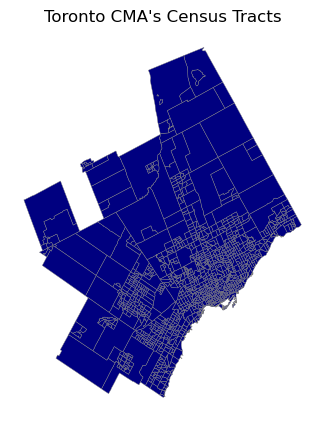

In [36]:
# basic plot
gdf.plot(
    figsize=(5,5), color='navy', edgecolor='grey', linewidth=0.3
)

plt.title("Toronto CMA's Census Tracts")
plt.axis('off')

plt.show()

The primary key that bind the Census of Population and Census Tract datasets is the `DGUID` column. Joining the Census Tract dataset will allow the addition of geometry values to any  population subset in this analysis. Join operations will be performed in a controlled manner to ensure that performance is not compromised and only when a map visualization or spatial analysis is needed.

The **Toronto Census Metropolitan Area (CMA)** contain more than just the city of Toronto boundary. It also contains Scarborough, Missisauga, Orangeville, Vaughan, Markham and extends north to Georgina Island. It is important to note that, when defining the area of interest, a decision must be made whether to focus solely on the City of Toronto or to use the entire Toronto CMA as defined.

# EDA by subtopic and characteristics

The dataset is now ready for EDA by subtopic, which will be performed independently. Then, the `CHARACTERISTIC_ID` will be dropped.

## Place of birth for the immigrant population in private households

According to the dictionary, place of birth refers to the name of the geographic location where a person was born. The geographic location is specified according to the geographic boundaries current at the time of data collection, not those at the time of birth. 

In the *2021 Census of Population*, and in the case of the immigrant population, it refers to a country or area of interest outside Canada.

In [37]:
# splitting the df by subtopic and characteristic
#  group 1: Place of birth for the immigrant population in private households
df1=df[df["CHARACTERISTIC_ID"].between(1544,1603)].reset_index().drop(columns=["CHARACTERISTIC_ID","index"])

In [38]:
df1.head()

,DGUID,CHARACTERISTIC_NAME,C1_COUNT_TOTAL,SYMBOL,C2_COUNT_MEN+,SYMBOL.1,C3_COUNT_WOMEN+,SYMBOL.2
0,2021S05075350001.00,Total - Place of birth for the immigrant popul...,145.0,,80.0,,60.0,
1,2021S05075350001.00,Americas,30.0,,20.0,,10.0,
2,2021S05075350001.00,Brazil,0.0,,0.0,,0.0,
3,2021S05075350001.00,Colombia,0.0,,0.0,,0.0,
4,2021S05075350001.00,El Salvador,0.0,,0.0,,0.0,


In [39]:
df1.groupby("DGUID")["CHARACTERISTIC_NAME"].nunique().unique().item()

60

There are **60** characteristics per census tract, some of them aggregate others. There is a three level hierarchy that goes from total, country, and continent.

In [40]:
# get all unique Characteristic Name
unique_values=df1['CHARACTERISTIC_NAME'].unique().tolist()

In [41]:
# print all in one go (not affected by pandas row truncation)
print("\n".join(map(str, unique_values)))

Total - Place of birth for the immigrant population in private households - 25% sample data
  Americas
    Brazil
    Colombia
    El Salvador
    Guyana
    Haiti
    Jamaica
    Mexico
    Peru
    Trinidad and Tobago
    United States of America
    Other places of birth in Americas
  Europe
    Bosnia and Herzegovina
    Croatia
    France
    Germany
    Greece
    Hungary
    Italy
    Netherlands
    Poland
    Portugal
    Romania
    Russian Federation
    Serbia
    Ukraine
    United Kingdom
    Other places of birth in Europe
  Africa
    Algeria
    Congo, Democratic Republic of the
    Egypt
    Eritrea
    Ethiopia
    Morocco
    Nigeria
    Somalia
    South Africa, Republic of
    Other places of birth in Africa
  Asia
    Afghanistan
    Iran
    Iraq
    Lebanon
    Syria
    Turkey
    China
    Hong Kong
    Korea, South
    Taiwan
    Philippines
    Viet Nam
    Bangladesh
    India
    Pakistan
    Sri Lanka
    Other places of birth in Asia
  Oceania and other

The hierarchy is implied by the number of blank spaces within the strings. The hierarchy must be explicit in a new columns to filter out the levels that are of any interest. The country level is the only relevant for this phase.

In [42]:
# create a characteristic hierarchy column
df1["CHARACTERISTIC_LEVEL"]=df1["CHARACTERISTIC_NAME"].str.extract(r'^(\s*)')[0].str.len()

In [43]:
# map unique values 
df1["CHARACTERISTIC_LEVEL"].unique()

array([0, 2, 4])

In [44]:
# define the hiearchy value of characteristic level
df1["CHARACTERISTIC_LEVEL"]=df1["CHARACTERISTIC_LEVEL"].replace({
    0:1,
    2:2,
    4:3
})

In [45]:
df1.head()

,DGUID,CHARACTERISTIC_NAME,C1_COUNT_TOTAL,SYMBOL,C2_COUNT_MEN+,SYMBOL.1,C3_COUNT_WOMEN+,SYMBOL.2,CHARACTERISTIC_LEVEL
0,2021S05075350001.00,Total - Place of birth for the immigrant popul...,145.0,,80.0,,60.0,,1
1,2021S05075350001.00,Americas,30.0,,20.0,,10.0,,2
2,2021S05075350001.00,Brazil,0.0,,0.0,,0.0,,3
3,2021S05075350001.00,Colombia,0.0,,0.0,,0.0,,3
4,2021S05075350001.00,El Salvador,0.0,,0.0,,0.0,,3


It is now necessary to specify the continent each country belongs to and put aside the levels 1 and 2, as it represents a aggregated. Analysis will only be performed at the same level of characteristic. Starting with the level 3.

In [46]:
# new dataframe with CHARACTERISTIC LEVEL 1 only
df11=df1[df1["CHARACTERISTIC_LEVEL"]==1].reset_index(drop=True)

In [47]:
# pass CHARACTERISTIC NAME as an attribute
df11.attrs["CHARACTERISTIC_NAME"]=df11["CHARACTERISTIC_NAME"].unique().item()

# pass CHARACTERISTIC_LEVEL as an attribute
df11.attrs["CHARACTERISTIC_LEVEL"]=df11["CHARACTERISTIC_LEVEL"].unique().item()

In [48]:
# drop CHARACTERISTIC NAME, CHARACTERISTIC LEVEL columns
df11=df11.drop(columns=["CHARACTERISTIC_NAME","CHARACTERISTIC_LEVEL"])

In [49]:
df11.attrs

{'CHARACTERISTIC_NAME': 'Total - Place of birth for the immigrant population in private households - 25% sample data',
 'CHARACTERISTIC_LEVEL': 1}

In [50]:
df11.head()

,DGUID,C1_COUNT_TOTAL,SYMBOL,C2_COUNT_MEN+,SYMBOL.1,C3_COUNT_WOMEN+,SYMBOL.2
0,2021S05075350001.00,145.0,,80.0,,60.0,
1,2021S05075350002.00,125.0,,50.0,,75.0,
2,2021S05075350003.00,215.0,,125.0,,90.0,
3,2021S05075350004.00,2600.0,,1245.0,,1360.0,
4,2021S05075350005.00,2525.0,,1145.0,,1375.0,


In [51]:
# new dataframe with CHARACTERISTIC LEVEL 2 only
df12=df1[df1["CHARACTERISTIC_LEVEL"]==2].reset_index(drop=True)

In [52]:
# pass CHARACTERISTIC_LEVEL as an attribute
df12.attrs["CHARACTERISTIC_LEVEL"]=df12["CHARACTERISTIC_LEVEL"].unique().item()

In [53]:
# drop CHARACTERISTIC LEVEL column
df12=df12.drop(columns="CHARACTERISTIC_LEVEL")

In [54]:
df12.attrs

{'CHARACTERISTIC_LEVEL': 2}

In [55]:
df12.head()

,DGUID,CHARACTERISTIC_NAME,C1_COUNT_TOTAL,SYMBOL,C2_COUNT_MEN+,SYMBOL.1,C3_COUNT_WOMEN+,SYMBOL.2
0,2021S05075350001.00,Americas,30.0,,20.0,,10.0,
1,2021S05075350001.00,Europe,50.0,,30.0,,15.0,
2,2021S05075350001.00,Africa,0.0,,0.0,,0.0,
3,2021S05075350001.00,Asia,65.0,,35.0,,30.0,
4,2021S05075350001.00,Oceania and other places of birth,0.0,,0.0,,0.0,


In [56]:
# filter out CHARACTERISTIC LEVEL 1 from LEVEL 3 only
df13=df1[df1["CHARACTERISTIC_LEVEL"]!=1].copy()

In [57]:
# create a CHARACTERISTIC_NAME_LEVEL_2 column with values at LEVEL 2
df13["CHARACTERISTIC_NAME_LEVEL_2"]=df13['CHARACTERISTIC_NAME'].where(df13['CHARACTERISTIC_LEVEL']==2)

In [58]:
# filling NaN with last valid value to next valid
df13["CHARACTERISTIC_NAME_LEVEL_2"]=df13["CHARACTERISTIC_NAME_LEVEL_2"].ffill()

In [59]:
# store CHARACTERISTIC LEVEL 2 and LEVEL 3 aside
df13_char_levels=df13[["CHARACTERISTIC_NAME_LEVEL_2","CHARACTERISTIC_NAME"]].drop_duplicates().reset_index(drop=True)

In [60]:
# rename CHARACTERISTIC NAME properly
df13_char_levels=df13_char_levels.rename(
    columns={
        "CHARACTERISTIC_NAME":"CHARACTERISTIC_NAME_LEVEL_3"
    }
)

In [61]:
df13_char_levels.head()

,CHARACTERISTIC_NAME_LEVEL_2,CHARACTERISTIC_NAME_LEVEL_3
0,Americas,Americas
1,Americas,Brazil
2,Americas,Colombia
3,Americas,El Salvador
4,Americas,Guyana


In [62]:
# filter out rows with continents at lvl 3
mask = ~(
    (df13_char_levels['CHARACTERISTIC_NAME_LEVEL_2'] == df13_char_levels['CHARACTERISTIC_NAME_LEVEL_3'])
    & (df13_char_levels['CHARACTERISTIC_NAME_LEVEL_2'] != '  Oceania and other places of birth')
)

df13_char_levels = df13_char_levels[mask]

In [63]:
df13_char_levels.head()

,CHARACTERISTIC_NAME_LEVEL_2,CHARACTERISTIC_NAME_LEVEL_3
1,Americas,Brazil
2,Americas,Colombia
3,Americas,El Salvador
4,Americas,Guyana
5,Americas,Haiti


In [64]:
# filter out CHARACTERISTIC LEVEL 2
df13=df13[df13["CHARACTERISTIC_LEVEL"]!=2]

In [65]:
# pass CHARACTERISTIC_LEVEL as an attribute
df13.attrs["CHARACTERISTIC_LEVEL"]=df13["CHARACTERISTIC_LEVEL"].unique().item()

In [66]:
df13.attrs

{'CHARACTERISTIC_LEVEL': 3}

In [67]:
# drop CHARACTERISTIC_LEVEL, CHARACTERISTIC_NAME_LEVEL_2 columns
df13=df13.drop(columns=["CHARACTERISTIC_LEVEL","CHARACTERISTIC_NAME_LEVEL_2"])

In [68]:
df13.head()

,DGUID,CHARACTERISTIC_NAME,C1_COUNT_TOTAL,SYMBOL,C2_COUNT_MEN+,SYMBOL.1,C3_COUNT_WOMEN+,SYMBOL.2
2,2021S05075350001.00,Brazil,0.0,,0.0,,0.0,
3,2021S05075350001.00,Colombia,0.0,,0.0,,0.0,
4,2021S05075350001.00,El Salvador,0.0,,0.0,,0.0,
5,2021S05075350001.00,Guyana,0.0,,0.0,,0.0,
6,2021S05075350001.00,Haiti,0.0,,0.0,,0.0,


### Characteristic Level 1

The level 1 in the Characteristic variable is a total aggregation count. The `C1_COUNT_TOTAL` values does not neccesarily matches the sum of `C2_COUNT_MEN+` and `C3_COUNT_WOMEN+`.

In [69]:
df11.head()

,DGUID,C1_COUNT_TOTAL,SYMBOL,C2_COUNT_MEN+,SYMBOL.1,C3_COUNT_WOMEN+,SYMBOL.2
0,2021S05075350001.00,145.0,,80.0,,60.0,
1,2021S05075350002.00,125.0,,50.0,,75.0,
2,2021S05075350003.00,215.0,,125.0,,90.0,
3,2021S05075350004.00,2600.0,,1245.0,,1360.0,
4,2021S05075350005.00,2525.0,,1145.0,,1375.0,


In [70]:
#  descriptive statistics for each numeric variable
df11.describe().round(2)

,C1_COUNT_TOTAL,C2_COUNT_MEN+,C3_COUNT_WOMEN+
count,1227.00,1227.00,1227.00
mean,2333.13,1094.71,1238.41
std,1329.53,631.70,702.64
min,0.00,0.00,0.00
25%,1397.50,650.00,745.00
50%,2195.00,1040.00,1165.00
75%,3037.50,1445.00,1635.00
max,16835.00,8205.00,8625.00


Descriptive statistics of Men+ and Women+ are quite similar, with slight bigger mean, Q1 and Q3 for Women+.

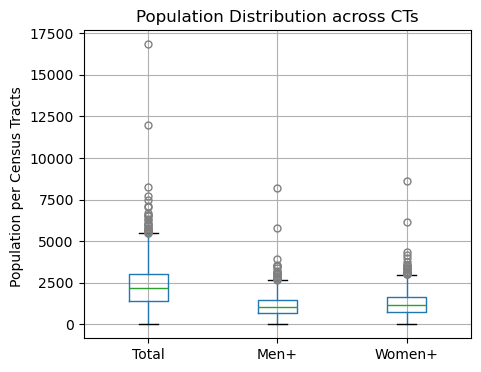

In [71]:
# boxplot of the Total, Men+ and Women+ counts
df11.boxplot(figsize=(5, 4), 
             flierprops=dict(markeredgecolor='grey', 
                             markersize= 5,
                             linewidth = .6))

plt.title("Population Distribution across CTs")
plt.ylabel("Population per Census Tracts ")
plt.xticks(ticks=[1,2,3], labels=['Total', 'Men+', 'Women+'])

plt.show()

The population per census tract boxplots shows that men+ and women+ have similar distributions patterns. Both have upper fence values above **2,500** people per CT, with the the women+ group showing a slightly higher upper fence. Their median values are close as well, indicating comparable central tendencies between both populations.

The interquartlie range for the women+ population is marginally wider, suggesting more variability across census tracts compared to men+. Both groups display upper fence values that extend beyond **2,500**, and their maximum observed values surpass **8,200** individuals per CT, indicating some tracts with notably high populations.

The Total Population Distribution, the median of **2195** lies around the center of the IQR, suggesting a fairly symmetrical distribution. It also has a wider IQR compared to both men+ and women+, as expected. 

The distance between the median and the upper whisker (approximately **5,500**) indicates a right skew in the total population distribution, characterized by a longer tail of census tracts with larger populations. There are numerous upper outliers that extend up to the maximum observed value of around **16,835**, reinforcing the right-skewed pattern of the distribution and the presence of extreme values in total population counts.

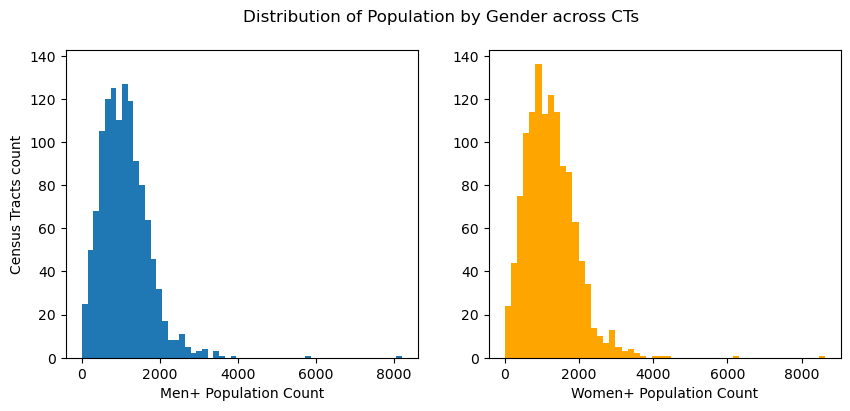

In [72]:
# histograms of the Distribution of Total Population by Gender across Census Tracts

fig,axes=plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# hist for Men+
axes[0].hist(df11["C2_COUNT_MEN+"],bins='fd',histtype='bar')
axes[0].set_xlabel("Men+ Population Count")
axes[0].set_ylabel("Census Tracts count")
#axes[0].set_title("Distribution of Men+ Population across Census Tracts")

# hist for Women+
axes[1].hist(df11["C3_COUNT_WOMEN+"],bins='fd',histtype='bar',color='orange')
axes[1].set_xlabel("Women+ Population Count")
#axes[1].set_title("Distribution of Women+ Population across Census Tracts")
axes[1].tick_params(labelleft=True)

# common title
fig.suptitle("Distribution of Population by Gender across CTs")

plt.show()

As observed before, both men+ and women+ population distributions are quite symmetrical and skewed to the right. 

In [73]:
# left join
gdf11 = gdf.merge(df11[["DGUID","C1_COUNT_TOTAL"]], on='DGUID')

In [74]:
gdf11.head()

,DGUID,LANDAREA,geometry,C1_COUNT_TOTAL
0,2021S05075350420.13,1.8675,"POLYGON ((7218613.794 949619.114, 7218679.703 ...",3865.0
1,2021S05075350422.03,3.5903,"POLYGON ((7219855.811 954804.291, 7219916.443 ...",4090.0
2,2021S05075350422.04,0.8388,"POLYGON ((7217958.14 954705.514, 7217957.497 9...",2415.0
3,2021S05075350422.05,1.5519,"POLYGON ((7216908.84 954698.554, 7216912.983 9...",4425.0
4,2021S05075350422.06,1.8382,"POLYGON ((7215728.211 952217.103, 7215620.917 ...",2995.0


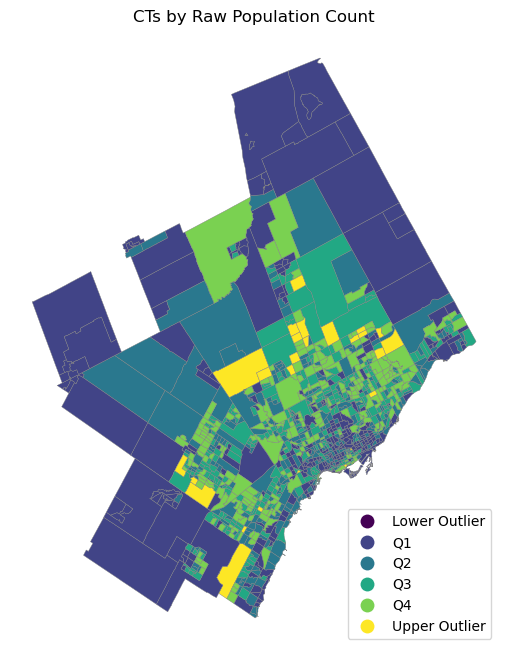

In [75]:
# calculate quartiles
Q1 = gdf11['C1_COUNT_TOTAL'].quantile(0.25)
Q2 = gdf11['C1_COUNT_TOTAL'].quantile(0.50)
Q3 = gdf11['C1_COUNT_TOTAL'].quantile(0.75)

# calculate IQR
IQR = Q3 - Q1

# define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# define bins and labels
bins = [-float('inf'), lower_bound, Q1, Q2, Q3, upper_bound, float('inf')]
labels = ['Lower Outlier', 'Q1', 'Q2', 'Q3', 'Q4', 'Upper Outlier']

# categorize values
gdf11['category'] = pd.cut(gdf11['C1_COUNT_TOTAL'], bins=bins, labels=labels)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# plot with category colors
gdf11.plot(
    column='category', categorical=True, legend=True, legend_kwds={'loc': 'lower right'}, 
    ax=ax, cmap='viridis', edgecolor='grey', linewidth=0.3)

ax.set_title("CTs by Raw Population Count")
ax.set_axis_off()
plt.show()

The raw (non-normalized) total population counts shows that CTs with lower population counts are primarily located at the outer edges of the area of interest. As one moves toward the urban core of City of Toronto, the population counts generally increase, reaching up to the **third quartile (Q3)**.

The census tracts identified as **Upper Outliers**, the ones above Q3, are spatially scattered but tend to cluster near adjacent to the Q3 tracts. Many of the tracts in **Q4 (above the 75th percentile)** are located in smaller geographic areas, suggesting that these CTs have high population **density**.

### Characteristic Level 2

In [76]:
df12.head()

,DGUID,CHARACTERISTIC_NAME,C1_COUNT_TOTAL,SYMBOL,C2_COUNT_MEN+,SYMBOL.1,C3_COUNT_WOMEN+,SYMBOL.2
0,2021S05075350001.00,Americas,30.0,,20.0,,10.0,
1,2021S05075350001.00,Europe,50.0,,30.0,,15.0,
2,2021S05075350001.00,Africa,0.0,,0.0,,0.0,
3,2021S05075350001.00,Asia,65.0,,35.0,,30.0,
4,2021S05075350001.00,Oceania and other places of birth,0.0,,0.0,,0.0,


In [77]:
df12.groupby("CHARACTERISTIC_NAME").describe().round(2)

C1_COUNT_TOTAL                         \
                                           count     mean      std  min   
CHARACTERISTIC_NAME                                                       
Africa                                    1227.0   140.98   138.48  0.0   
Americas                                  1227.0   334.34   242.94  0.0   
Asia                                      1227.0  1400.74  1120.11  0.0   
Europe                                    1227.0   450.77   325.74  0.0   
Oceania and other places of birth         1227.0     4.69     7.91  0.0   

                                                                   \
                                     25%     50%     75%      max   
CHARACTERISTIC_NAME                                                 
Africa                              55.0   105.0   180.0   1470.0   
Americas                           175.0   270.0   435.0   2065.0   
Asia                               550.0  1165.0  1952.5  13150.0   
Europe                             220.0   375.0   605.0   2275.0   
Oceania and other places of birth    0.0     0.0    10.0     45.0   

                                  C2_COUNT_MEN+                              \
                                          count    mean     std  min    25%   
CHARACTERISTIC_NAME                                                           
Africa                                   1227.0   68.06   67.16  0.0   25.0   
Americas                                 1227.0  148.29  107.29  0.0   75.0   
Asia                                     1227.0  662.67  536.84  0.0  260.0   
Europe                                   1227.0  212.31  152.32  0.0  102.5   
Oceania and other places of birth        1227.0    1.88    4.61  0.0    0.0   

                                                        C3_COUNT_WOMEN+  \
                                     50%    75%     max           count   
CHARACTERISTIC_NAME                                                       
Africa                              50.0   90.0   750.0          1227.0   
Americas                           120.0  192.5   895.0          1227.0   
Asia                               555.0  927.5  6530.0          1227.0   
Europe                             180.0  280.0  1040.0          1227.0   
Oceania and other places of birth    0.0    0.0    25.0          1227.0   

                                                                              \
                                     mean     std  min    25%    50%     75%   
CHARACTERISTIC_NAME                                                            
Africa                              72.89   73.70  0.0   25.0   55.0    95.0   
Americas                           185.98  138.54  0.0   95.0  150.0   240.0   
Asia                               737.93  586.00  0.0  295.0  615.0  1030.0   
Europe                             238.60  176.27  0.0  115.0  195.0   320.0   
Oceania and other places of birth    1.86    4.65  0.0    0.0    0.0     0.0   

                                           
                                      max  
CHARACTERISTIC_NAME                        
Africa                              770.0  
Americas                           1160.0  
Asia                               6620.0  
Europe                             1280.0  
Oceania and other places of birth    35.0

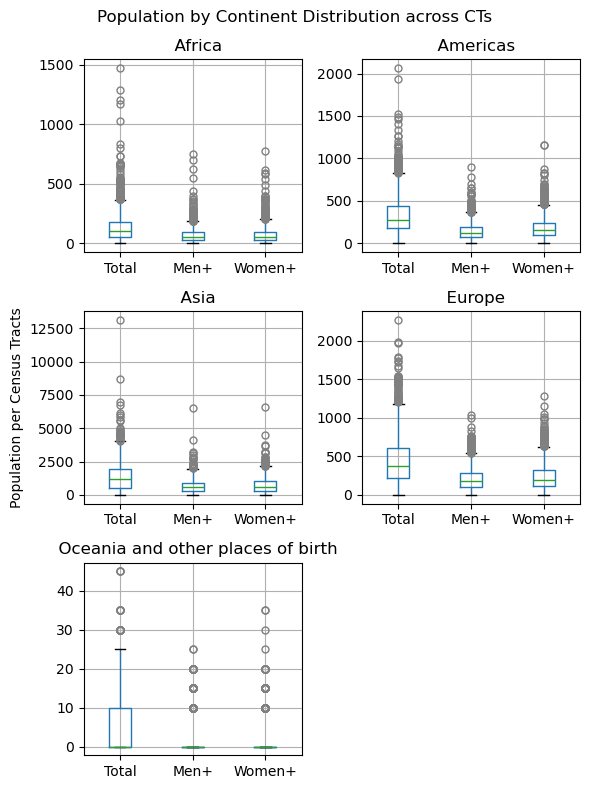

In [78]:
groups = df12.groupby("CHARACTERISTIC_NAME")
n = len(groups)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(6, 8), sharey=False)
axes = axes.flatten()

for ax, (name, group) in zip(axes, groups):
    group.boxplot(column=['C1_COUNT_TOTAL', 'C2_COUNT_MEN+', 'C3_COUNT_WOMEN+'], ax=ax,
                  flierprops=dict(markeredgecolor='grey',markersize= 5,linewidth = .6))
                      
    ax.set_title(name)
    ax.set_xticklabels(['Total', 'Men+', 'Women+'])
    
axes[2].set_ylabel("Population per Census Tracts")

# turn off unused axes if any
for i in range(len(groups), len(axes)):
    axes[i].axis('off')

# Add spacing between subplots
plt.suptitle("Population by Continent Distribution across CTs")
plt.tight_layout()

plt.show()

All population distributions by continent or origin show a **right-skewed pattern**. This is evident from the fact that the **mean is consistently greater than the median**, and the presence of **long right tails** is suggested by high maximum values compared to the quartiles. In general, the medians tend to fall closer to the first quartile (Q1) than to the third quartile (Q3), further indicating skeweness.

For each continent, the women+ population tend to have **slighter medians and wider interquartile ranges (IQRs)** compared to the men+ distributions. This suggests more variability and slightly larger populations among women+ groups across the tracts.

Among all groups, the **Asian population** stands out with the **highest median value of 1,165**, which is significantly large thatn the next nighest median, **375 for Europe**.

#### Pivot to wide format

The dataset will be transformed in a wide format, so that there will be one row per `ALT_GEO_CODE`. As the dataframe has three count values: total, men+ and women+, the df will be divided by each one of the counts. This operation will keep the df readable.

In [79]:
# new CHARACTERISTIC LEVEL 2 total count only dataframe
df12_c1_total=df12[["DGUID","CHARACTERISTIC_NAME","C1_COUNT_TOTAL","SYMBOL"]].copy()

In [80]:
# unique symbol values
df12_c1_total["SYMBOL"].value_counts()

SYMBOL
     6110
x      25
Name: count, dtype: int64

There is no relevant quality value in `SYMBOL`. So, it can be dropped.

In [81]:
# drop SYMBOL
df12_c1_total=df12_c1_total.drop(columns="SYMBOL")

In [82]:
# wide format df
df12_c1_total_wide=df12_c1_total.pivot_table(index="DGUID",columns="CHARACTERISTIC_NAME",sort=False,
                                             values=["C1_COUNT_TOTAL"],aggfunc='sum')

In [83]:
df12_c1_total_wide.head()

C1_COUNT_TOTAL                        \
CHARACTERISTIC_NAME       Americas Europe Africa    Asia   
DGUID                                                      
2021S05075350001.00           30.0   50.0    0.0    65.0   
2021S05075350002.00           25.0   95.0    0.0     0.0   
2021S05075350003.00           35.0   45.0   10.0   125.0   
2021S05075350004.00          420.0  560.0  150.0  1465.0   
2021S05075350005.00          455.0  645.0  320.0  1090.0   

                                                       
CHARACTERISTIC_NAME Oceania and other places of birth  
DGUID                                                  
2021S05075350001.00                               0.0  
2021S05075350002.00                               0.0  
2021S05075350003.00                               0.0  
2021S05075350004.00                              10.0  
2021S05075350005.00                               0.0

The dataframe has a wider format. Although, it has a multi-level index that has to be flattened. The variable `ALT_GEO_CODE` is now the row-index column, and it has to be released. The column `C1_COUNT_TOTAL` is now in the level 0, and it has to be also released.

In [84]:
# flatten the multi-index
#  drop the index row level 1: ALT_GEO_CODE
df12_c1_total_wide=df12_c1_total_wide.reset_index(col_level=1)

In [85]:
#  drop C1_COUNT_TOTAL from the column level 0  
df12_c1_total_wide.columns=df12_c1_total_wide.columns.droplevel(0)

In [86]:
#  drop CHARACTERISTIC_NAME out of the row-index 
df12_c1_total_wide.columns.name=None 

In [87]:
df12_c1_total_wide.head()

,DGUID,Americas,Europe,Africa,Asia,Oceania and other places of birth
0,2021S05075350001.00,30.0,50.0,0.0,65.0,0.0
1,2021S05075350002.00,25.0,95.0,0.0,0.0,0.0
2,2021S05075350003.00,35.0,45.0,10.0,125.0,0.0
3,2021S05075350004.00,420.0,560.0,150.0,1465.0,10.0
4,2021S05075350005.00,455.0,645.0,320.0,1090.0,0.0


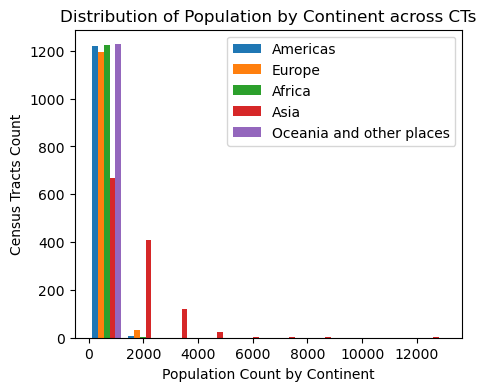

In [88]:
# histogram of the Distribution of Population by Continents across Census Tracts
plt.figure(figsize=(5, 4))

plt.hist(df12_c1_total_wide[["  Americas","  Europe","  Africa","  Asia","  Oceania and other places of birth"]],
        label=["Americas","Europe","Africa","Asia","Oceania and other places"]
        )

plt.legend()
plt.xlabel("Population Count by Continent")
plt.ylabel("Census Tracts Count")
plt.title("Distribution of Population by Continent across CTs")

plt.show()

The histogram of Population Distribution by continent shows that for most continents, their populations are represented across nearly all **1,227 CTs**. For Africa, the Americas and Europe, the median population values are relatively close (**105**, **270**, and **375**), respectively. Suggesting that these populations are present in **moderate and comparable amounts**, with variation still present, as indicated by their standard deviations.

In contrast, the **Asian** population distribution is heavily skewed. A significant portion of its population is concentrated in fewer tracts. Specially, fewer than 400 CTs have Asian population counts above 2,000.

### Characteristic Level 3

#### Pivot to wide format

The dataset will be transformed in a wide format, so that there will be one row per `ALT_GEO_CODE`. As the dataframe has three count values: total, men+ and women+, the df will be divided by each one of the counts. This operation will keep the df readable.

In [89]:
# new CHARACTERISTIC LEVEL 3, total count only dataframe
df13_c1_total=df13[["DGUID","CHARACTERISTIC_NAME","C1_COUNT_TOTAL","SYMBOL"]].copy()

In [90]:
# unique symbol values
df13_c1_total["SYMBOL"].value_counts()

SYMBOL
     65988
x      270
Name: count, dtype: int64

There is no relevant quality value in `SYMBOL`. So, it can be dropped.

In [91]:
# drop SYMBOL
df13_c1_total=df13_c1_total.drop(columns="SYMBOL")

In [92]:
# wide format df
df13_c1_total_wide=df13_c1_total.pivot_table(index="DGUID",columns="CHARACTERISTIC_NAME",sort=False,
                                             values=["C1_COUNT_TOTAL"],aggfunc='sum')

In [93]:
df13_c1_total_wide.head()

C1_COUNT_TOTAL                                            \
CHARACTERISTIC_NAME         Brazil Colombia El Salvador Guyana Haiti Jamaica   
DGUID                                                                          
2021S05075350001.00            0.0      0.0         0.0    0.0   0.0     0.0   
2021S05075350002.00            0.0      0.0         0.0    0.0   0.0     0.0   
2021S05075350003.00            0.0      0.0         0.0    0.0   0.0     0.0   
2021S05075350004.00           15.0     10.0        15.0   20.0   0.0    50.0   
2021S05075350005.00           25.0     10.0        25.0   80.0   0.0    75.0   

                                                                               \
CHARACTERISTIC_NAME Mexico  Peru Trinidad and Tobago United States of America   
DGUID                                                                           
2021S05075350001.00    0.0   0.0                 0.0                     10.0   
2021S05075350002.00    0.0   0.0                 0.0                     20.0   
2021S05075350003.00    0.0   0.0                 0.0                      0.0   
2021S05075350004.00   25.0   0.0                70.0                     85.0   
2021S05075350005.00   15.0  10.0                70.0                     30.0   

                                                                              \
CHARACTERISTIC_NAME Other places of birth in Americas Bosnia and Herzegovina   
DGUID                                                                          
2021S05075350001.00                              10.0                    0.0   
2021S05075350002.00                               0.0                    0.0   
2021S05075350003.00                              20.0                    0.0   
2021S05075350004.00                             115.0                   25.0   
2021S05075350005.00                             110.0                   15.0   

                                                                             \
CHARACTERISTIC_NAME Croatia France Germany Greece Hungary Italy Netherlands   
DGUID                                                                         
2021S05075350001.00     0.0    0.0     0.0    0.0     0.0   0.0         0.0   
2021S05075350002.00     0.0    0.0    15.0    0.0     0.0   0.0         0.0   
2021S05075350003.00     0.0   10.0     0.0    0.0     0.0   0.0         0.0   
2021S05075350004.00    10.0   35.0    15.0   15.0    40.0  20.0         0.0   
2021S05075350005.00     0.0   30.0    40.0   25.0     0.0  10.0         0.0   

                                                                               \
CHARACTERISTIC_NAME Poland Portugal Romania Russian Federation Serbia Ukraine   
DGUID                                                                           
2021S05075350001.00   10.0      0.0     0.0                0.0    0.0     0.0   
2021S05075350002.00   25.0      0.0     0.0                0.0    0.0     0.0   
2021S05075350003.00    0.0      0.0     0.0                0.0    0.0     0.0   
2021S05075350004.00  110.0     25.0     0.0               25.0   35.0    20.0   
2021S05075350005.00  190.0     90.0    25.0               40.0   10.0    35.0   

                                                                            \
CHARACTERISTIC_NAME United Kingdom Other places of birth in Europe Algeria   
DGUID                                                                        
2021S05075350001.00           10.0                            20.0     0.0   
2021S05075350002.00           30.0                            25.0     0.0   
2021S05075350003.00            0.0                            10.0     0.0   
2021S05075350004.00           45.0                           150.0     0.0   
2021S05075350005.00           85.0                            50.0     0.0   

                                                                              \
CHARACTERISTIC_NAME Congo, Democratic Republic of the Egypt Eritrea Ethiopia   
DGUID                 

The dataframe has a wider format. Although, it has a multi-level index that has to be flattened. The variable `ALT_GEO_CODE` is now the row-index column, and it has to be released. The column `C1_COUNT_TOTAL` is now in the level 0, and it has to be also released.

In [94]:
# flatten the multi-index
#  drop the index row level 1: ALT_GEO_CODE
df13_c1_total_wide = df13_c1_total_wide.reset_index(col_level=1)

In [95]:
#  drop C1_COUNT_TOTAL from the column level 0  
df13_c1_total_wide.columns = df13_c1_total_wide.columns.droplevel(0)

In [96]:
#  drop CHARACTERISTIC_NAME out of the row-index 
df13_c1_total_wide.columns.name = None 

In [97]:
df13_c1_total_wide.head()

,DGUID,Brazil,Colombia,El Salvador,Guyana,Haiti,Jamaica,Mexico,Peru,Trinidad and Tobago,United States of America,Other places of birth in Americas,Bosnia and Herzegovina,Croatia,France,Germany,Greece,Hungary,Italy,Netherlands,Poland,Portugal,Romania,Russian Federation,Serbia,Ukraine,United Kingdom,Other places of birth in Europe,Algeria,"Congo, Democratic Republic of the",Egypt,Eritrea,Ethiopia,Morocco,Nigeria,Somalia,"South Africa, Republic of",Other places of birth in Africa,Afghanistan,Iran,Iraq,Lebanon,Syria,Turkey,China,Hong Kong,"Korea, South",Taiwan,Philippines,Viet Nam,Bangladesh,India,Pakistan,Sri Lanka,Other places of birth in Asia
0,2021S05075350001.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,10.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,20.0,0.0,0.0,0.0,0.0,20.0
1,2021S05075350002.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,30.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021S05075350003.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,0.0,0.0,25.0
3,2021S05075350004.00,15.0,10.0,15.0,20.0,0.0,50.0,25.0,0.0,70.0,85.0,115.0,25.0,10.0,35.0,15.0,15.0,40.0,20.0,0.0,110.0,25.0,0.0,25.0,35.0,20.0,45.0,150.0,0.0,0.0,10.0,20.0,45.0,0.0,0.0,10.0,0.0,55.0,0.0,20.0,10.0,10.0,0.0,15.0,190.0,25.0,0.0,0.0,250.0,100.0,10.0,500.0,10.0,50.0,265.0
4,2021S05075350005.00,25.0,10.0,25.0,80.0,0.0,75.0,15.0,10.0,70.0,30.0,110.0,15.0,0.0,30.0,40.0,25.0,0.0,10.0,0.0,190.0,90.0,25.0,40.0,10.0,35.0,85.0,50.0,0.0,10.0,15.0,35.0,65.0,30.0,20.0,25.0,0.0,115.0,10.0,25.0,20.0,0.0,0.0,10.0,95.0,20.0,30.0,0.0,225.0,160.0,35.0,270.0,20.0,40.0,115.0


In [98]:
# aggregating counts by country
df13_c1_total_wide_sum = df13_c1_total_wide.drop(columns="DGUID").sum()

In [99]:
#  from Series to Data Frame object
df13_c1_total_wide_sum = df13_c1_total_wide_sum.reset_index()

In [100]:
#  name columns
df13_c1_total_wide_sum.columns = ['CHARACTERISTIC_NAME_LEVEL_3','n']

In [101]:
df13_c1_total_wide_sum.head()

,CHARACTERISTIC_NAME_LEVEL_3,n
0,Brazil,13505.0
1,Colombia,15195.0
2,El Salvador,8510.0
3,Guyana,64215.0
4,Haiti,1170.0


In [102]:
# add continent
df13_c1_total_wide_sum = df13_char_levels.merge(df13_c1_total_wide_sum, on="CHARACTERISTIC_NAME_LEVEL_3")

In [103]:
df13_c1_total_wide_sum.head()

,CHARACTERISTIC_NAME_LEVEL_2,CHARACTERISTIC_NAME_LEVEL_3,n
0,Americas,Brazil,13505.0
1,Americas,Colombia,15195.0
2,Americas,El Salvador,8510.0
3,Americas,Guyana,64215.0
4,Americas,Haiti,1170.0


In [104]:
# sort countries by continent and population
df13_c1_total_wide_sum = df13_c1_total_wide_sum.sort_values(by=["CHARACTERISTIC_NAME_LEVEL_2", "n"])

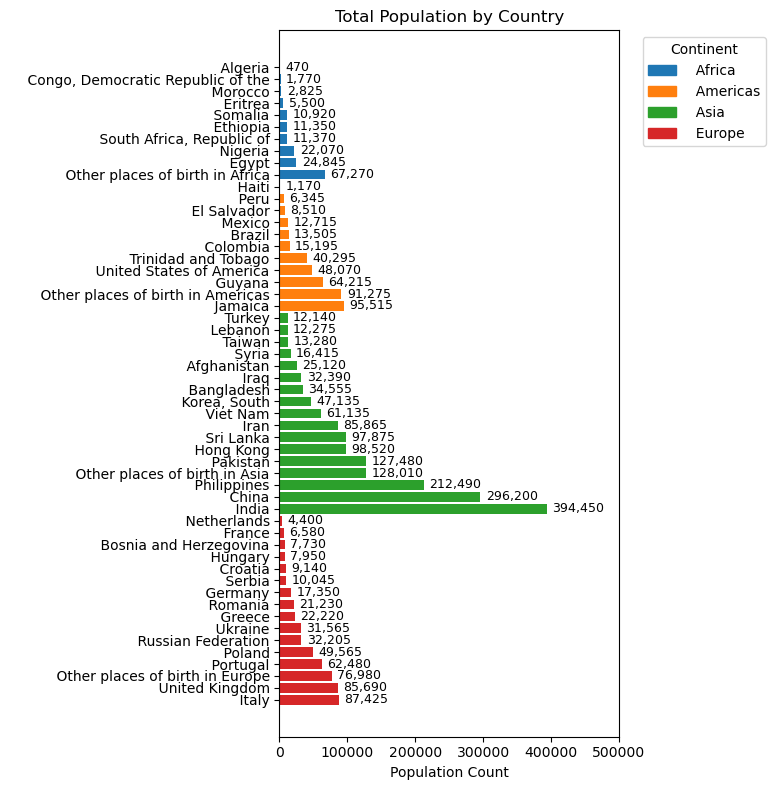

In [105]:
# unique colors per continent
continents = df13_c1_total_wide_sum["CHARACTERISTIC_NAME_LEVEL_2"].unique()
# a set of 10 distinct colors
colors = plt.cm.tab10.colors 

# create a mapping from continent to color
color_map = {cont: colors[i % len(colors)] for i, cont in enumerate(continents)}

# map colors for each row based on continent
bar_colors = df13_c1_total_wide_sum["CHARACTERISTIC_NAME_LEVEL_2"].map(color_map)

# horizontal bar graph of the Total Population by Country
plt.figure(figsize=(8,8))

bars = plt.barh(df13_c1_total_wide_sum["CHARACTERISTIC_NAME_LEVEL_3"],df13_c1_total_wide_sum["n"],
               color=bar_colors)

# add total count next to each bar
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + max(df13_c1_total_wide_sum["n"]) * 0.02,  # small offset to the right
        bar.get_y() + bar.get_height() / 2,
        f'{int(width):,}',  # formatted with commas
        va='center',
        ha='left',
        fontsize=9
    )

plt.gca().invert_yaxis()
plt.xlabel("Population Count")
plt.title("Total Population by Country")
plt.xlim(0, 500_000)

# create custom legend handles
handles = [mpatches.Patch(color=color_map[cont], label=cont) for cont in continents]
plt.legend(handles=handles, title="Continent", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


The total population by contry os shown in detail, not only listing the population of each country but also ranking them in ascending order. Starting with **Africa**, the largest population group comes from **Egypt** with a total of **24,845**. Howerver, the smaller populations combined from other African countries, not even listed, result in a total that is **almost three times** larger than Egypt's.

In the case of the **Americas**, the largest group of inmigrants come from **Jamaica**, with **95,515 people**, followed by the aggregated population of smaller groups. **Guyana** has the third-largest group from the Americas, with **64,215 people**. 

For **Europe**, **Italy** has the largest group with **87,425 people**, and followed by **United Kingdom** with a **85,690**. **Portugal** falls in the fourth place with a population of **62,480**.

All of this countries have relatively similar populations compared to **Asian** countries. **Pakinstan**, the **Philipinnes**, **China** and **India** all have larger populations than the largest groups from any other continent. The ascending order of population sizes among Asian countries closely resembles an exponential distribution. At the top, **India** has by far the largest inmigrant group, with **394,450** people, followed by **China** with **296,200** and **Philippines** with **212,490**. counts.

#### Calculate Shannon Index

The Shannon Index measures diverisity

In [106]:
# define Shannon Index function
def shannon_index(row):
    
    counts = row.values
    total = counts.sum()
    
    if total==0:
        return 0.0 # avoid division by zero
    
    proportions = counts/total
    
    # Filter out zero proportions to avoid log(0)
    nonzero_props = proportions[proportions > 0]
    
    return -np.sum(nonzero_props * np.log(nonzero_props))

In [107]:
# calculate Shannon Index per Census Tract
df13_c1_total_wide["SHANNON_INDEX"]=df13_c1_total_wide.drop(columns="DGUID").apply(shannon_index,axis=1)

In [108]:
df13_c1_total_wide["SHANNON_INDEX"].describe()

count    1227.000000
mean        2.676498
std         0.500308
min         0.000000
25%         2.456057
50%         2.790818
75%         3.009389
max         3.481913
Name: SHANNON_INDEX, dtype: float64

In [109]:
df13_c1_total_wide.head()

,DGUID,Brazil,Colombia,El Salvador,Guyana,Haiti,Jamaica,Mexico,Peru,Trinidad and Tobago,United States of America,Other places of birth in Americas,Bosnia and Herzegovina,Croatia,France,Germany,Greece,Hungary,Italy,Netherlands,Poland,Portugal,Romania,Russian Federation,Serbia,Ukraine,United Kingdom,Other places of birth in Europe,Algeria,"Congo, Democratic Republic of the",Egypt,Eritrea,Ethiopia,Morocco,Nigeria,Somalia,"South Africa, Republic of",Other places of birth in Africa,Afghanistan,Iran,Iraq,Lebanon,Syria,Turkey,China,Hong Kong,"Korea, South",Taiwan,Philippines,Viet Nam,Bangladesh,India,Pakistan,Sri Lanka,Other places of birth in Asia,SHANNON_INDEX
0,2021S05075350001.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,10.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,20.0,0.0,0.0,0.0,0.0,20.0,2.019815
1,2021S05075350002.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,30.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.583931
2,2021S05075350003.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,0.0,0.0,25.0,1.858462
3,2021S05075350004.00,15.0,10.0,15.0,20.0,0.0,50.0,25.0,0.0,70.0,85.0,115.0,25.0,10.0,35.0,15.0,15.0,40.0,20.0,0.0,110.0,25.0,0.0,25.0,35.0,20.0,45.0,150.0,0.0,0.0,10.0,20.0,45.0,0.0,0.0,10.0,0.0,55.0,0.0,20.0,10.0,10.0,0.0,15.0,190.0,25.0,0.0,0.0,250.0,100.0,10.0,500.0,10.0,50.0,265.0,3.045061
4,2021S05075350005.00,25.0,10.0,25.0,80.0,0.0,75.0,15.0,10.0,70.0,30.0,110.0,15.0,0.0,30.0,40.0,25.0,0.0,10.0,0.0,190.0,90.0,25.0,40.0,10.0,35.0,85.0,50.0,0.0,10.0,15.0,35.0,65.0,30.0,20.0,25.0,0.0,115.0,10.0,25.0,20.0,0.0,0.0,10.0,95.0,20.0,30.0,0.0,225.0,160.0,35.0,270.0,20.0,40.0,115.0,3.378941


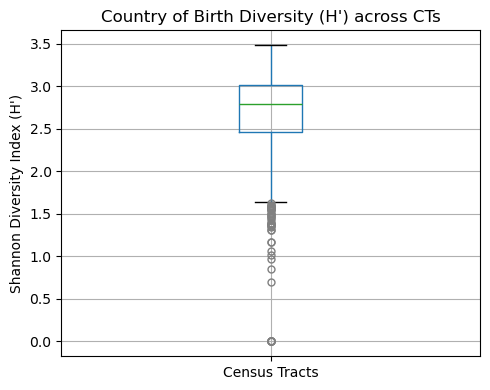

In [110]:
# boxplot of the Shannon Index 
df13_c1_total_wide[["DGUID","SHANNON_INDEX"]].boxplot(
    figsize=(5, 4), flierprops=dict(markeredgecolor='grey', 
                                    markersize= 5,linewidth = .6)
)

plt.title("Country of Birth Diversity (H') across CTs")
plt.ylabel("Shannon Diversity Index (H')")
plt.xticks(ticks=[1], labels=['Census Tracts'])

plt.tight_layout()
plt.show()

The boxplot of Country of Birth Diversity Index (H') across CTs shows a moderate diversity across the CTs. The relatively small standard deviation of 0.5 suggest that most values fall close to the average and that the distribution has a small spread. The mean and median are close, meaning that the data is roughly symmetric.

The distribution is mildly left-skewed. It has a tail of lower end outliers ranging from zero to approximately 1.63 in the Shannon Diversity Index (H'). This suggest that there are CTs with populations predominantly from one country of birth. In contrast, above the median, there are CTs that have a wide variation in diversity, reaching up to 3.48 and indicating a higher mix of countries of origin.

In [111]:
# left join
gdf13_c1_total_wide = gdf.merge(df13_c1_total_wide[["DGUID","SHANNON_INDEX"]], on='DGUID')

In [112]:
gdf13_c1_total_wide.head()

,DGUID,LANDAREA,geometry,SHANNON_INDEX
0,2021S05075350420.13,1.8675,"POLYGON ((7218613.794 949619.114, 7218679.703 ...",2.706657
1,2021S05075350422.03,3.5903,"POLYGON ((7219855.811 954804.291, 7219916.443 ...",2.407671
2,2021S05075350422.04,0.8388,"POLYGON ((7217958.14 954705.514, 7217957.497 9...",1.992241
3,2021S05075350422.05,1.5519,"POLYGON ((7216908.84 954698.554, 7216912.983 9...",2.188702
4,2021S05075350422.06,1.8382,"POLYGON ((7215728.211 952217.103, 7215620.917 ...",2.891908


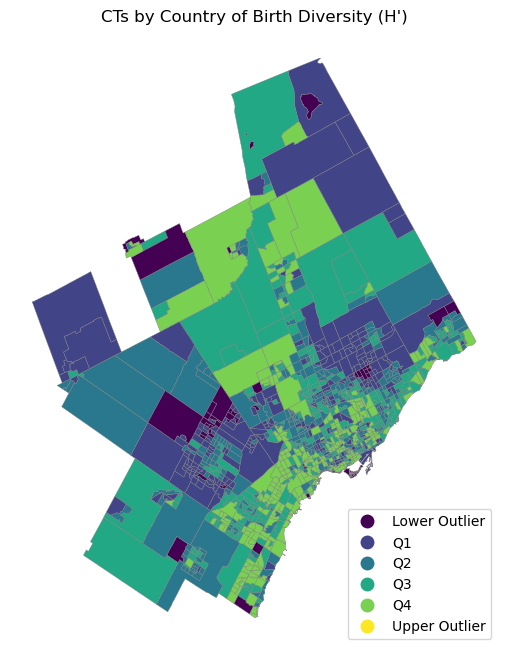

In [113]:
# calculate quartiles
Q1 = gdf13_c1_total_wide['SHANNON_INDEX'].quantile(0.25)
Q2 = gdf13_c1_total_wide['SHANNON_INDEX'].quantile(0.50)
Q3 = gdf13_c1_total_wide['SHANNON_INDEX'].quantile(0.75)

# calculate IQR
IQR = Q3 - Q1

# define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# define bins and labels
bins = [-float('inf'), lower_bound, Q1, Q2, Q3, upper_bound, float('inf')]
labels = ['Lower Outlier', 'Q1', 'Q2', 'Q3', 'Q4', 'Upper Outlier']

# categorize values
gdf13_c1_total_wide['category'] = pd.cut(gdf13_c1_total_wide['SHANNON_INDEX'], bins=bins, labels=labels)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# plot with category colors
gdf13_c1_total_wide.plot(
    column='category', categorical=True, legend=True, legend_kwds={'loc': 'lower right'}, 
    ax=ax, cmap='viridis', edgecolor='grey', linewidth=0.3)

ax.set_title("CTs by Country of Birth Diversity (H')")
ax.set_axis_off()
plt.show()


The map of the Diversity Index (H') shows that more diverse CTs are located near the urban areas of Toronto CMA, and toward the north. In contrast, diversity level drops **belows the first quartile (Q1)** in adjacent areas both at the east and west. As it gets afar from the city core, diveristy level generally ranges between the **second quartile (Q2)** and **third quartiles (Q3)**.

CTs identified with **lower-end outliers**, with significantly low diversity, are scattered across the region and do not display any particular spatial pattern or clustering.


# Next Steps

There are two other subtopics related to the inmigrant population that may be included in this analysis:

- **Place of birth for the recent immigrant population in private household**. It would be interesting to compare the numbers between recent inmgrants and the overall inmigrant population to see if there are significant changes.
- **Ethnic or cultural origin for the population in private households**. Analysing the population by cultural origin would also provide an interesting perspective, as culture and country of origin may overlap but are not necessarily equivalent.

In [114]:
# splitting the df by subtopic and characteristic

#  group 2: Place of birth for the recent immigrant population in private households
#df2=df[df["CHARACTERISTIC_ID"].between(1604,1664)].reset_index().drop(columns=["CHARACTERISTIC_ID","index"])

#  group 3: Ethnic or cultural origin for the population in private households
#df3=df[df["CHARACTERISTIC_ID"].between(1698,1948)].reset_index().drop(columns=["CHARACTERISTIC_ID","index"])

# Resouces

- [Census Profile, 2021 Census of Population](https://www12.statcan.gc.ca/census-recensement/2021/dp-pd/prof/index.cfm?Lang=E)
- [About the Census Profile, 2021 Census of Population](https://www12.statcan.gc.ca/census-recensement/2021/dp-pd/prof/about-apropos/about-apropos.cfm?Lang=E#aa1)
- [Guide to the Census of Population, 2021](https://www12.statcan.gc.ca/census-recensement/2021/ref/98-304/index-eng.cfm),  provides an overview of the Census of Population content determination, collection, processing, data quality assessment and data dissemination. It may be useful to both new and experienced users who wish to familiarize themselves with and find specific information about the 2021 Census
- [Filling the gaps: Information on gender in the 2021 Census](https://www12.statcan.gc.ca/census-recensement/2021/ref/98-20-0001/982000012021001-eng.cfm), defines gender, sex at birth, and relevant concepts as the Census 2021 disseminates census information on gender
- [Census Profile metadata](https://www12.statcan.gc.ca/census-recensement/2021/dp-pd/prof/about-apropos/metadata-metadonnees-eng.cfm), list characteristics by topics and subtopic, and list all footnotes
- [Full Table Download (CSV) User Guide](https://www.statcan.gc.ca/en/developers/csv/user-guide), provides users with a guide to the full table downloadable output files available from the Statistics Canada website
- [Dictionary, Census of Population 2021, PDF version](https://www12.statcan.gc.ca/census-recensement/2021/ref/dict/98-301-x2021001-eng.pdf), is a reference document which contains detailed definitions of Census of Population concepts, variables and geographic terms, as well as historical information. The PDF version organizes the concepts by topics, which is not the case for the [web version](https://www12.statcan.gc.ca/census-recensement/2021/ref/dict/index-eng.cfm).
- [2021 Census – Boundary files](https://www12.statcan.gc.ca/census-recensement/2021/geo/sip-pis/boundary-limites/index2021-eng.cfm?year=21)
- [Boundary Files, Reference Guide, Census year 2021, Second Edition](https://www150.statcan.gc.ca/n1/en/catalogue/92-160-G2021002)

# Reference

Statistics Canada. 2023. Census Profile. 2021 Census of Population. Statistics Canada Catalogue number 98-316-X2021001. Ottawa. Released November 15, 2023.
*https://www12.statcan.gc.ca/census-recensement/2021/dp-pd/prof/index.cfm?Lang=E (accessed August 4, 2025).*